In [1]:
import os
import time
import warnings
import numpy as np
import pandas as pd
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

Using TensorFlow backend.


In [2]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()

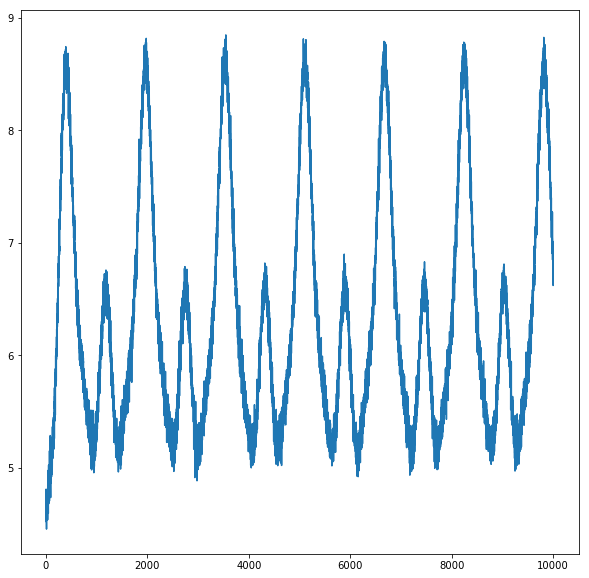

In [3]:
def func(x):
    y = np.sin(x)+ np.power(np.tanh(x*x), 3)+ np.cos(np.pi*np.cos(x))+ 5.6
    y = np.array(y)
    
    noise_ = np.random.normal(0, 0.1, y.shape)
    y_noise = np.add(y, noise_)
        
    return y, y_noise
    
t = np.linspace(0, 40, 10000)
data_, data_noise = func(t)

# plot of the graph
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(data_noise)
plt.show()
fig.savefig('data.png', bbox_inches='tight')

In [ ]:
np.savetxt("random.csv", data_, delimiter="\n")
np.savetxt("random_noise.csv", data_noise, delimiter="\n")

In [4]:
# Loading data

def load_data(filename, seq_len, normalise_window = False, normalise_window_std = False):
    f = open(filename, 'rb').read()
    data = f.decode().split('\n')
    data = pd.DataFrame(data[:-1], dtype='float').values
        
    if normalise_window_std:
        data = normalise_windows_std(data)

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window and not normalise_window_std:
        print('Majid')
        result = normalise_windows(result)

    result = np.array(result)

    row = round(0.9 * result.shape[0])
    
    train_unshuffle = result[:int(row), :]
    x_train_unshuffle = train_unshuffle[:, :-1]
    y_train_unshuffle = train_unshuffle[:, -1]
    
    train = result[:int(row), :]
    #np.random.shuffle(train)
    rows = [i for i in range(row)]
    np.random.shuffle(rows)
    x_train = train[rows, :-1]
    y_train = train[rows, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test, x_train_unshuffle, y_train_unshuffle]


# not doing normalization at this moment for this dataset
# Also consider this later

def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def normalise_windows_std(total_data):
    stdscale = StandardScaler()
    stdscale.fit(total_data)
    normalised_data = stdscale.transform(total_data)
    return normalised_data


In [5]:
x_train, y_train, x_test, y_test, x_train_unshuffle, y_train_unshuffle = load_data('./random_noise.csv'
                                            , 50, normalise_window= True, normalise_window_std= True)

In [6]:
# layers = [1, 50, 100, 1]
def build_model(layers):
    model = Sequential()
    # You can specify the input_shape argument that expects a tuple containing
    # the number of timesteps [50 in this case] and the number of features [1 in this case]
    model.add(LSTM(layers[1],
        input_shape=(layers[1], layers[0]),
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print("> Compilation Time : ", time.time() - start)
    return model

In [7]:
model = build_model([1, 50, 100, 1])

> Compilation Time :  0.011137008666992188


In [8]:
fitted_model = model.fit(
                x_train,
                y_train,
                batch_size=512,
                epochs=10,
                verbose=1,
                validation_split=0.05)

Train on 8506 samples, validate on 448 samples
Epoch 1/10
8506/8506 [==============================] - 5s 539us/step - loss: 0.1476 - val_loss: 0.0235

In [32]:
fitted_model.history

{'loss': [0.14756240334879461,
  0.030743881269094664,
  0.030678704365222503,
  0.029885403723025668,
  0.026824178962028645,
  0.024046114770936006,
  0.024701148435795781,
  0.023368100964396583,
  0.023606990021034856,
  0.021587171866638419],
 'val_loss': [0.023499038070440292,
  0.024298042058944702,
  0.020560171455144882,
  0.018523547798395157,
  0.01741376705467701,
  0.013771401718258858,
  0.016685474663972855,
  0.021372433751821518,
  0.020585227757692337,
  0.019828546792268753]}

In [54]:
def evaluate_sequences_multiple(model, data, true_label, window_size, prediction_len):
    # Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        next_frame = data[(i+1)*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted += [model.evaluate(curr_frame[newaxis, :, :], true_label[i*prediction_len+ j], verbose=0)]
            curr_frame = curr_frame[1:]
            # this insert prediction at the end, and keeps going
            # prediction on prediction
            
            curr_frame = np.insert(curr_frame, [window_size-1], next_frame[j], axis=0)
            # curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
            
                        
        prediction_seqs += predicted
        
    prediction_seqs = np.array(prediction_seqs)
    error_ = np.mean(prediction_seqs)

    return error_

In [9]:
def predict_sequences_multiple(model, data, window_size, prediction_len):
    # Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        next_frame = data[(i+1)*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis, :, :])[0, 0])
            curr_frame = curr_frame[1:]
            # this insert prediction at the end, and keeps going
            # prediction on prediction
            
            curr_frame = np.insert(curr_frame, [window_size-1], next_frame[j], axis=0)
            # curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
            
        prediction_seqs.append(predicted)
    return prediction_seqs

In [10]:
prediction = predict_sequences_multiple(model, x_test, 50, 50)

In [55]:
eval_error = evaluate_sequences_multiple(model, x_test, y_test, 50, 50)

In [56]:
eval_error

0.020908662423355661

In [ ]:
# use this to plot prediction on the training set
prediction_train = predict_sequences_multiple(model, x_train_unshuffle[0:1001,:, :], 50, 50)

In [11]:
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white', figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    # Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

In [12]:
def plot_results_single(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white', figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data', linewidth=1)
    prediction_single = []
    for i, data in enumerate(predicted_data):
        prediction_single += predicted_data[i]
        
    plt.plot(prediction_single, label='Prediction', linewidth=3)
    plt.legend()
    plt.show()
    fig.savefig('prediction.png', bbox_inches='tight')

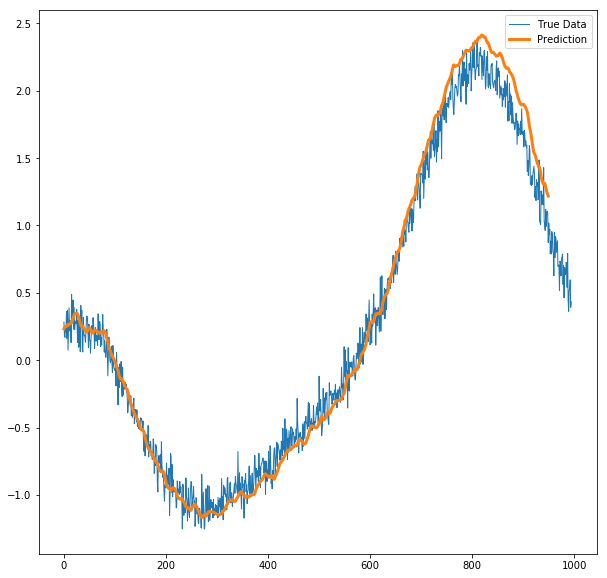

In [13]:
plot_results_single(prediction, y_test, 50)

In [ ]:
plot_results_multiple(prediction_train, y_train_unshuffle[0:1001], 50)